In [1]:
### IMPORT LIBRARIES ### 
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
from scipy.stats.stats import pearsonr   
import random
from tqdm import tqdm
import time

import networkx as nx

import matplotlib as mpl
def setup_mpl():
    mpl.rc("font", size=20)
setup_mpl()

# Q1d and Q1e: Erdos-Renyi
Giant component and clustering coefficient of ER graphs

In [34]:
### FUNCTIONS ###

def ER_mean_degree_clustering_and_giant_component(N, p): 
    '''Generate an Erdos-Renyi network with `N` nodes and probability `p` of connection,
    and returns its average_degree and normalised size of giant component.
    '''
    
    # Create network
    G = nx.erdos_renyi_graph (N, p)
    # Compute mean degree
    k_avg = np.mean (list(dict(G.degree()).values()))
    # Get giant component
    giant_component = sorted(nx.connected_components(G), key=len, reverse=True)[0]
    # Get size of giant component
    Gc_size = len(giant_component)/N
    
    return k_avg, Gc_size

In [30]:
### COMPUTE QUANTITIES ### (Takes some time ~1min)

### Q1d: size of giant component
N = 1000 # number of nodes
reps = 10 # number of repetitions for each values
probs = np.linspace (0, 0.004, 50) # connection probabilities

# Initialise vectors of average degree and giant component sizes
avg_degs, lcc_sizes = [], []
for p in probs:
    for r in range(reps):

        avg_deg, lcc_size = ER_mean_degree_clustering_and_giant_component(N, p)

        avg_degs.append( avg_deg )
        lcc_sizes.append( lcc_size )

### Q1e: average clustering
probs2 = np.linspace(0,0.1, 10)
avg_clusts, probabilities = [], []
for p in probs2:
    for r in range(reps):
        
        G = nx.erdos_renyi_graph(N, p)
        
        avg_clust = nx.average_clustering(G)
        
        avg_clusts.append( avg_clust )
        probabilities.append( p )

All quantities are simulated 10 times for each value on the x-axis.


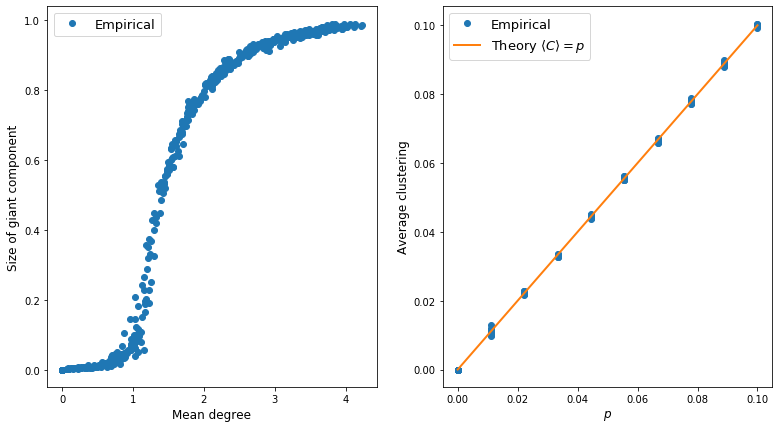

In [37]:
### VISUALISATION ###

print("All quantities are simulated {} times for each value on the x-axis.".format(reps))

# Canvas
plt.figure(figsize=(13,7))

# Plot for the mean
plt.subplot(121)
plt.plot(avg_degs, lcc_sizes, 'o', label='Empirical')
# plt.plot(probabilities, probabilities, lw=2, label=r'Theory, $\mathbb{E}[x]=p$')

plt.legend(fontsize=13)
plt.xlabel(r'Mean degree', fontsize=12)
plt.ylabel('Size of giant component', fontsize=12)

plt.subplot(122)
plt.plot(probabilities, avg_clusts, 'o', label='Empirical')
plt.plot(probs2, probs2, lw=2, label=r'Theory $\langle C \rangle=p$')
plt.legend(fontsize=13)
plt.xlabel(r'$p$', fontsize=12)
plt.ylabel('Average clustering', fontsize=12);

# Q2: Configuration model

In [9]:
# Create a random ER graph
p = 0.001

adj = (np.random.random(size=(200, 200)) < p).astype(int) # picking links at random
adj[np.triu_indices(adj.shape[0])] = 0 # setting the upper diagonal part of the matrix to zero
edgelist = np.where(adj > 0) # getting the edgelist
edgelist_original = sorted(list(zip(edgelist[0], edgelist[1])))
edgelist = sorted(list(zip(edgelist[0], edgelist[1])))


print("- Sneak peek of the edgelist: {} + ... ".format(edgelist[:10]))

m = len(edgelist)

print("- Total number of edges: {}. We should pick at least {:.0f} steps".format(m, .5*m*np.log(10*m)))


time.sleep(1)


- Sneak peek of the edgelist: [(62, 59), (71, 40), (81, 72), (88, 16), (95, 20), (97, 58), (103, 44), (111, 6), (120, 17), (121, 5)] + ... 
- Total number of edges: 16. We should pick at least 41 steps


In [10]:
# Randomization routine
n_randomizations = 10_000
n_steps = 140

results = np.zeros((n_randomizations, n_steps))

for i in tqdm(range(n_randomizations)):
    for j in range(n_steps):
        vavb, vcvd = np.random.choice(len(edgelist), size=2, replace=False)
        if (vavb == 0) or (vcvd == 0):
            results[i, j] = 1
            break

# Transforming our results
results = np.cumsum(results, axis=1) # Transforming each row like 01000 -> 01111
results = (~results.astype(bool)).astype(int) # Transforming each row like 0111 -> 1000

100%|██████████| 10000/10000 [00:08<00:00, 1225.29it/s]


[]

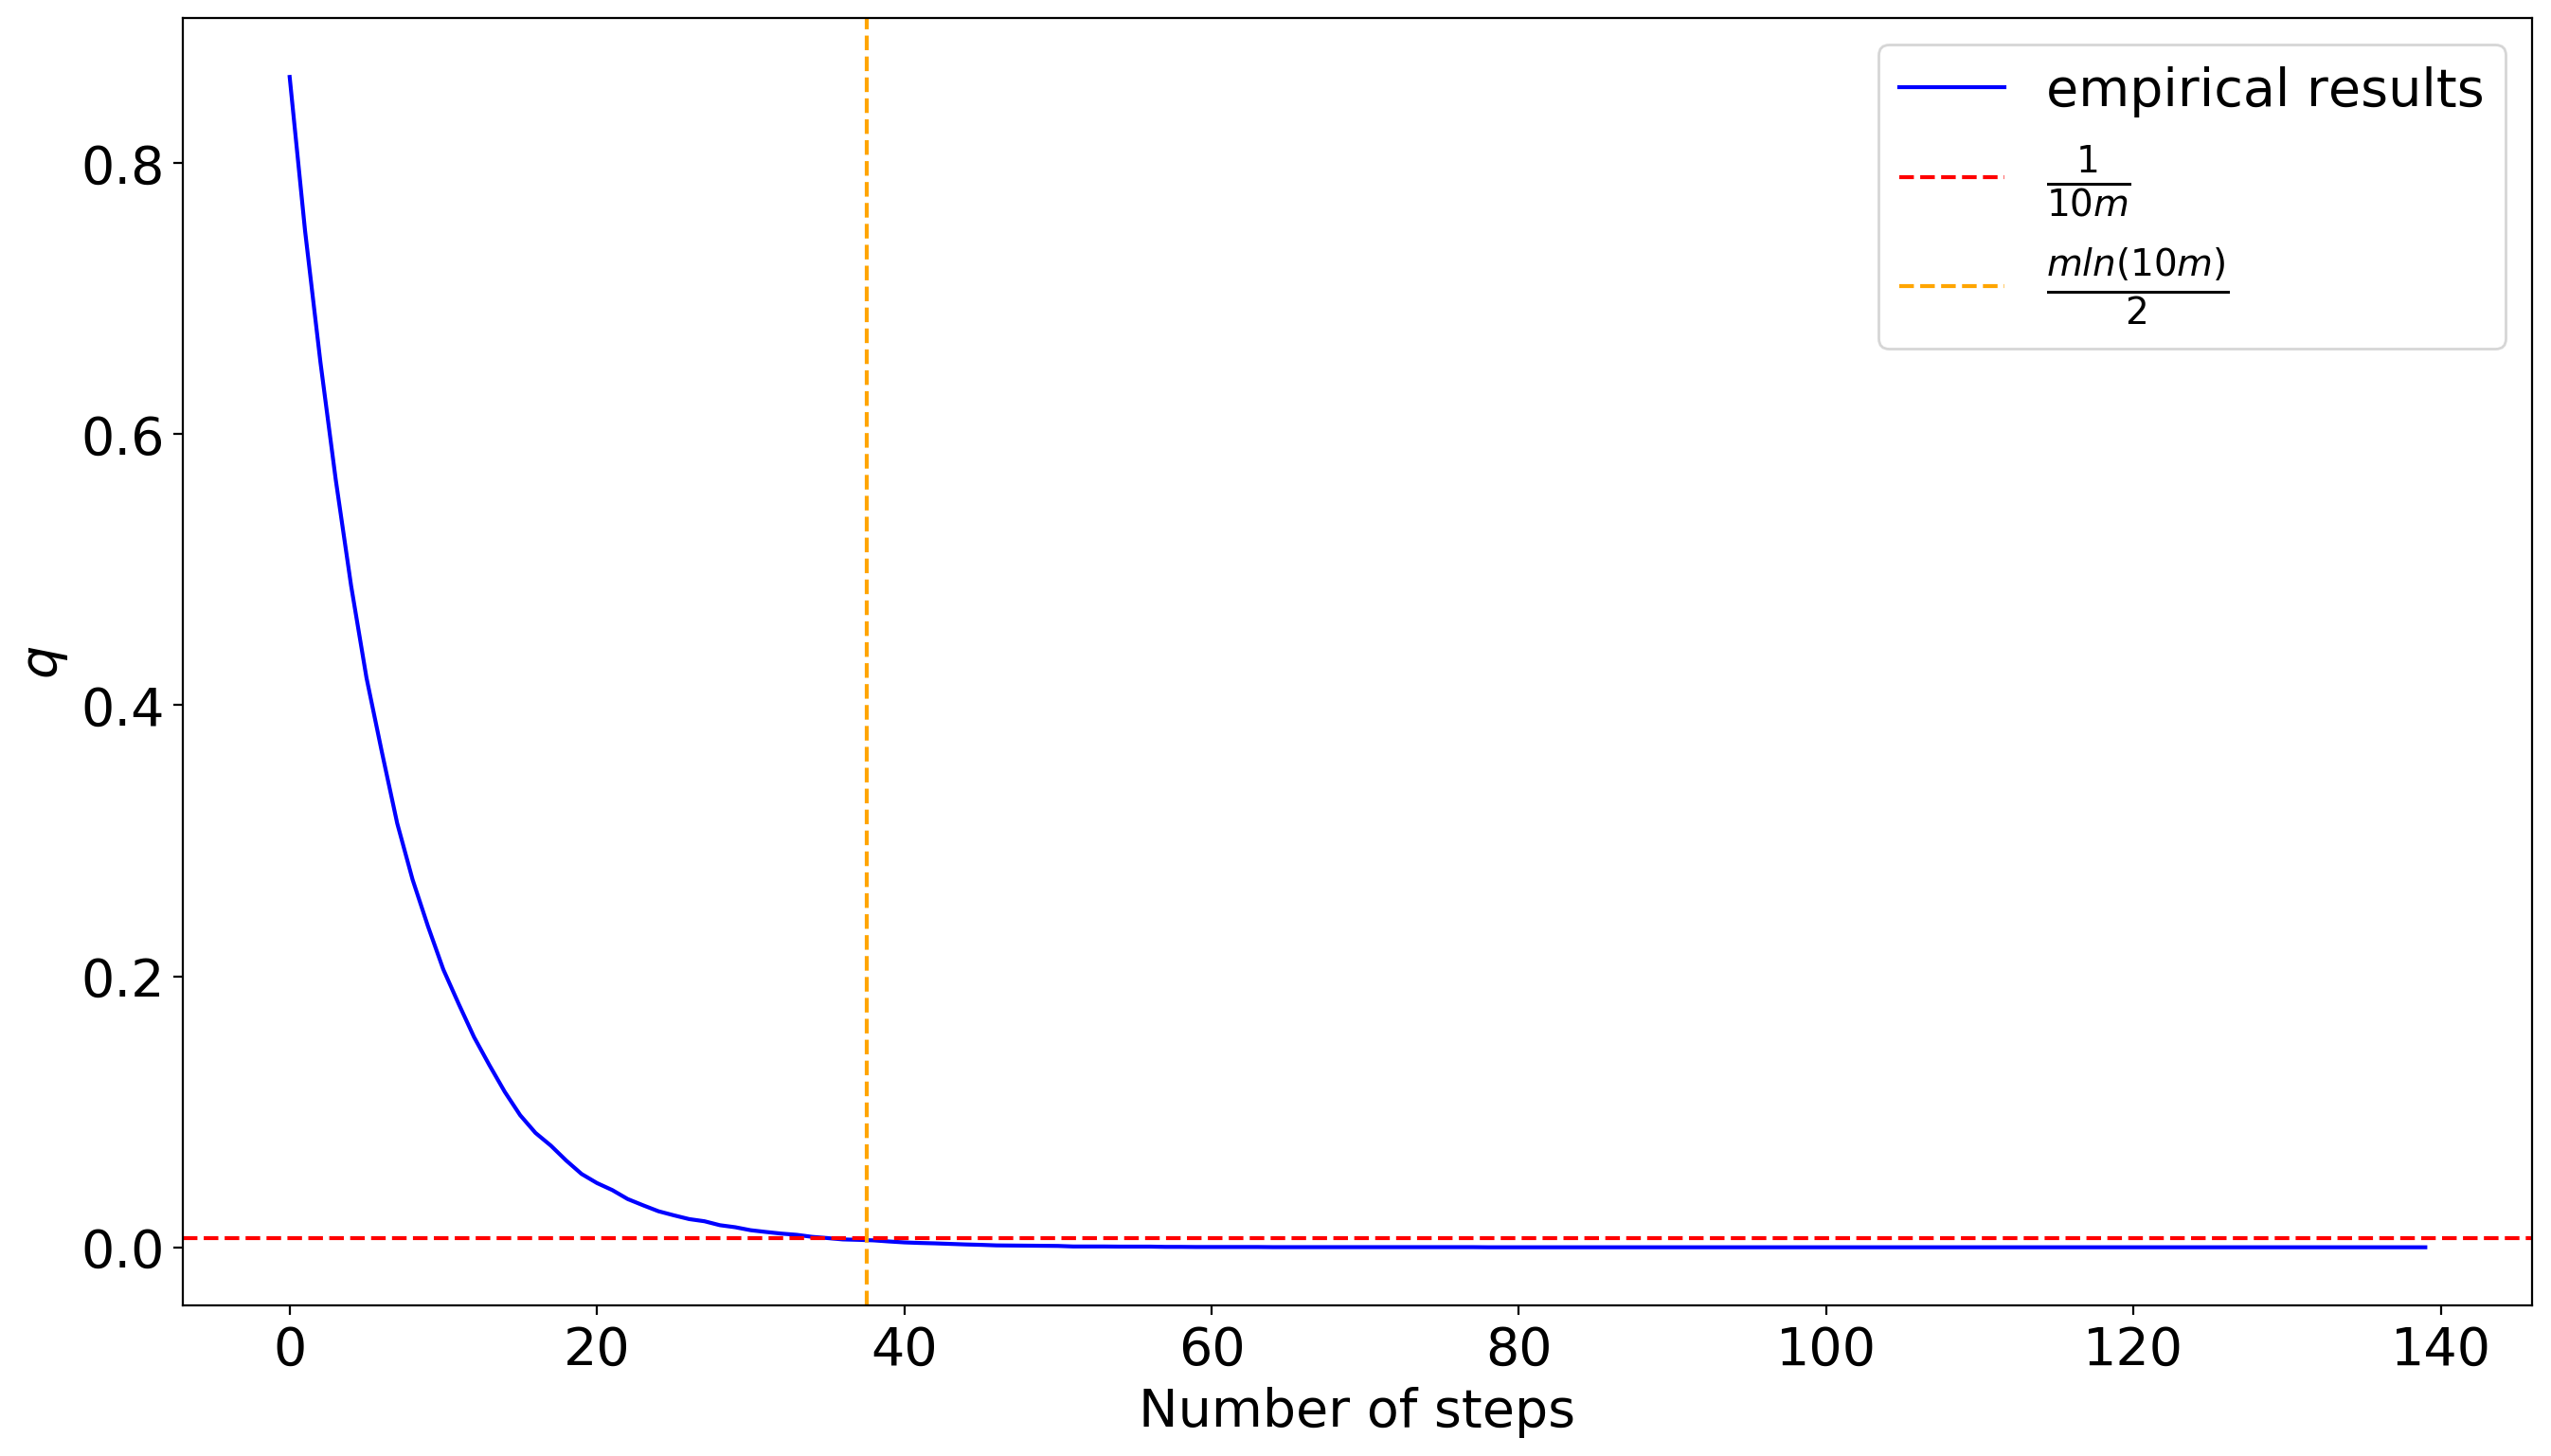

In [73]:
# Plotting results
fig, ax = plt.subplots(figsize=(16, 9), dpi=200)

ax.plot(results.mean(axis=0), color = "blue", label = "empirical results")
ax.axhline(0.1/m, ls = "--", color="red", label = r"$\frac{1}{10m}$")
ax.axvline(.5*m*np.log(10*m), ls = "--", color = "orange", label = r"$\frac{mln(10m)}{2}$")

ax.set_xlabel("Number of steps")
ax.set_ylabel("$q$")
ax.legend()


plt.plot()

# Range Dependent Networks

In [4]:
def generate_rd_probability(lambda_, alpha, n, in_a_circle=False):
    """
    Generates a matrix of size n whose ij entry is equal to
    alpha * lambda^(|i-j|-1), alpha > 0, lambda <= 1
    """
    assert (alpha > 0), 'alpha must be larger than 0'
    assert ((lambda_ >= 0) and (lambda_ <= 1)), 'lambda must be >0 and <1'
    
    prob_matrix = np.zeros((n, n))
    
    
    for i in range(n):
        for j in range(i):
            if (in_a_circle is True) and (i-j == n-1):
                    prob_matrix[i, j] = alpha
            else:
                prob_matrix[i, j] = alpha*np.power(lambda_, i-j-1)
    prob_matrix += prob_matrix.T
    return prob_matrix

def generate_rd_network(lambda_, alpha, n, in_a_circle=False):
    """
    Generates a range dependent network
    """
    rand = np.random.random(size=(n, n)) # Extract numbers at random
    rand[np.triu_indices(n)] = 0 #make rand symmetric
    rand = rand + rand.T
    
    prob = generate_rd_probability(lambda_, alpha, n, in_a_circle)
    
    adj = (rand < prob).astype(float)
    g = nx.from_numpy_matrix(adj)
    return g

/Users/lmng/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


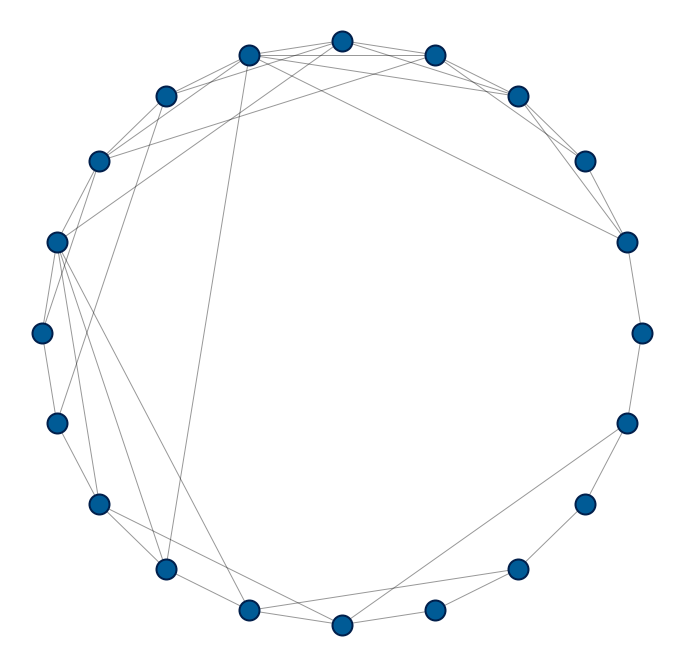

In [5]:
lambda_ = 0.5
alpha = 1
n = 20

g = generate_rd_network(lambda_, alpha, n, in_a_circle=True)

pos = nx.circular_layout(g)

fig, ax = plt.subplots(figsize=(12, 12))

nx.draw_networkx_nodes(g, pos=pos, node_size=400, node_color="#005B96", edgecolors="#011F4B", linewidths=2, ax=ax)
nx.draw_networkx_edges(g, pos=pos, node_size=400, color="#B3C2F2", alpha=.4, ax=ax)

ax.axis("off")
plt.show()

In [11]:
n_random = 100
n_nodes = 500

degrees = np.zeros((n_random, n_nodes))

for i in tqdm(range(n_random)):
    g = generate_rd_network(lambda_, alpha, n_nodes, in_a_circle=True)
    degrees[i, :] = np.array([d for d in dict(g.degree()).values()])
    
    
print("The averaage degree is {}; In theory it should be {:.2f}".format(degrees.mean(), 2*alpha/(1-lambda_)))

100%|██████████| 100/100 [00:29<00:00,  3.35it/s]

The averaage degree is 3.98952; In theory it should be 4.00


In [66]:
# 3.b

lambdas = np.linspace(0, 1, 20)
n_networks = 10

clustering_coeffs = np.zeros((n_networks, len(lambdas)))

for i in tqdm(range(n_networks)):
    for j, l in enumerate(lambdas):
        g = generate_rd_network(l, alpha, n_nodes, in_a_circle=True)
        clustering_coeffs[i, j] = nx.average_clustering(g)


100%|██████████| 10/10 [02:30<00:00, 15.03s/it]


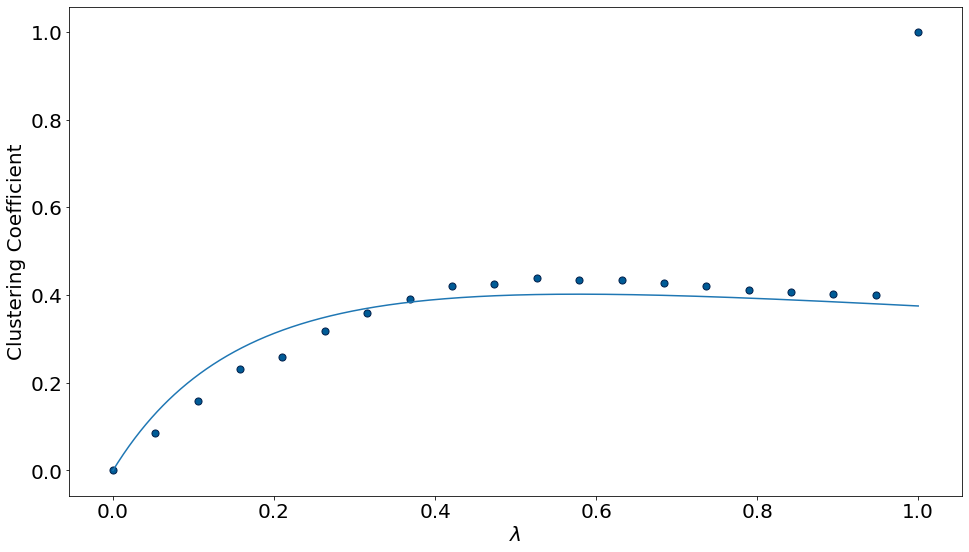

In [76]:
fig, ax = plt.subplots(figsize=(16, 9))

ax.scatter(lambdas, clustering_coeffs.mean(axis=0), marker="o", s=50, facecolor="#005B96", ec="#011F4B")

x = np.linspace(0, 1, 1000)
y_theory = (3*x)/((1+x)*(1+3*x))
ax.plot(x, y_theory, zorder=1)

ax.set_xlabel(f"$\lambda$")
ax.set_ylabel("Clustering Coefficient")
plt.show()